# ML method for finding path

17/01/2022


In this notebook I will use the ML method of the fine tuning.  
I can't do this right now. For now I will add some supplamentry codes over here.


the code is mainly taken from the colab notebook which is linked to [here](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).


In [1]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


In [2]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T


In [3]:
class RatImagesDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(
            sorted(os.listdir(os.path.join(root, "orig_frames"))))  # images
        self.masks = list(
            sorted(os.listdir(os.path.join(root, "colored_frames"))))  # masks

    def __getitem__(self, idx):
        # load images as masks
        img_path = os.path.join(self.root, "orig_frames", self.imgs[idx])
        mask_path = os.path.join(self.root, "colored_frames", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        # mask = Image.open(mask_path)
        npmask = np.array(Image.open(mask_path))
        if len(npmask[0][0]) != 3:
            print(img_path, len(npmask[0][0]))
            return [-1]
        reshaped = npmask.reshape(1, -1, 3)[0]
        applied = np.apply_along_axis(
            lambda arr: False if arr.sum() < 50 else True, 1, reshaped)
        npmask_mask = applied.reshape(npmask.shape[:-1])
        mask = np.where(npmask_mask, 1, 0)

        # mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


In [4]:
class RatImagesTestSet(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(
            sorted(os.listdir(root)))  # images

    def __getitem__(self, idx):
        # load images as masks
        img_path = os.path.join(self.root, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background

        # image_id = torch.tensor([idx])
        image_id = int(img_path.split(".")[-2].split("_")[-1][5:])
        target = {}
        target["image_id"] = image_id

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


In [5]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model


In [6]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


### create and train model


In [11]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# dataset = RatImagesDataset('./videos/uploadable/', get_transform(train=True))
# data_loader = torch.utils.data.DataLoader(
#     dataset, batch_size=1, shuffle=True, num_workers=1,
#     collate_fn=utils.collate_fn)

# # For Training
# images, targets = next(iter(data_loader))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images, targets)   # Returns losses and detections

# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)           # Returns predictions


In [7]:
# use our dataset and defined transformations
dataset = RatImagesDataset('./videos/uploadable/', get_transform(train=True))
dataset_test = RatImagesDataset(
    './videos/uploadable/', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
sep = int(len(indices) * 0.8)
dataset = torch.utils.data.Subset(dataset, indices[:sep])
dataset_test = torch.utils.data.Subset(dataset_test, indices[sep:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)


In [8]:
device = torch.device(
    'cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)


In [9]:
# let's train it for 20 epochs
# from torch.optim.lr_scheduler import StepLR
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader,
                    device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)


C:\Users\buein\Anaconda3\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\buein\Anaconda3\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [ 0/10]  eta: 0:09:34  lr: 0.000560  loss: 2.0562 (2.0562)  loss_classifier: 0.2922 (0.2922)  loss_box_reg: 0.0623 (0.0623)  loss_mask: 1.5229 (1.5229)  loss_objectness: 0.1702 (0.1702)  loss_rpn_box_reg: 0.0086 (0.0086)  time: 57.4167  data: 7.6200
Epoch: [0]  [ 9/10]  eta: 0:00:52  lr: 0.005000  loss: 0.7670 (1.1643)  loss_classifier: 0.1509 (0.1729)  loss_box_reg: 0.0644 (0.0989)  loss_mask: 0.4500 (0.8254)  loss_objectness: 0.0317 (0.0593)  loss_rpn_box_reg: 0.0072 (0.0078)  time: 52.6844  data: 8.8218
Epoch: [0] Total time: 0:08:46 (52.6883 s / it)
creating index...
index created!
Test:  [0/5]  eta: 0:01:44  model_time: 14.6060 (14.6060)  evaluator_time: 0.0450 (0.0450)  time: 20.9100  data: 6.2560
Test:  [4/5]  eta: 0:00:20  model_time: 14.6060 (14.0384)  evaluator_time: 0.0240 (0.0279)  time: 20.0971  data: 6.0286
Test: Total time: 0:01:40 (20.0981 s / it)
Averaged stats: model_time: 14.6060 (14.0384)  evaluator_time: 0.0240 (0.0279)
Accumulating evaluation results..

### analyze results
**TODO:** read video frames and run both algorithms on the video.

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\buein\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['indices']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [11]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

img = img.mul(255).permute(1, 2, 0).byte().numpy()
mask = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
mean_point = array(nonzero(mask)).mean(axis=1)


<ipython-input-12-d63da1fae3e9>:7: UserWarning: The following kwargs were not used by contour: 'linewidth'
  contour(X, Y, mask, levels, colors='C0', linewidth=1)


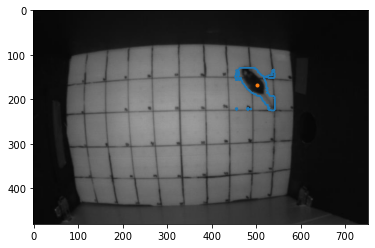

In [12]:
x = range(mask.shape[1])
y = range(mask.shape[0])
X, Y = meshgrid(x, y)
levels = arange(0, 0.2, 0.1)

imshow(img)
contour(X, Y, mask, levels, colors='C0', linewidth=1)
plot([mean_point[1]], [mean_point[0]], ".", color="C1")


### read video frames

In [16]:
from glob import glob
import pandas
import shutil

In [32]:
os.mkdir("temp_for_testing")
for f in glob('videos/frames/Odor1_*'):
    shutil.copy2(f, "temp_for_testing")

In [17]:
rgb2gray = lambda rgb: np.dot(rgb, [0.2989, 0.5870, 0.1140])

dataset_test = RatImagesTestSet(
    './temp_for_testing/', get_transform(train=False))

In [18]:
masks = {}
mean_points = {}
gray_frames = {}

model.eval()
c = 0
with torch.no_grad():
    for img, d in dataset_test:
        i = d['image_id']
        c += 1
        if c > 500:
            break
        if c % 10 == 0:
            print(c, end=', ')
        prediction = model([img.to(device)])
        img = img.mul(255).permute(1, 2, 0).byte().numpy()
        masks[i] = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
        mean_points[i] = np.array(np.nonzero(masks[i])).mean(axis=1)
        gray_frames[i] = img # rgb2gray(img)

10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 

In [150]:
mps = pandas.DataFrame(mean_points, index=['y', 'x']).T
mps.index.name = 'timestep'

In [151]:
gray_frames.keys()

dict_keys([0, 1, 10, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 11, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 12, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 13, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 14, 140, 141, 142])

<AxesSubplot:xlabel='x', ylabel='y'>

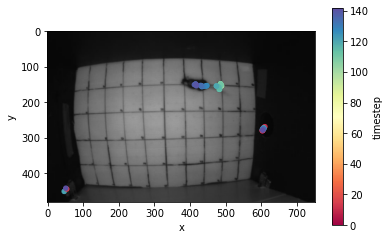

In [157]:
imshow(gray_frames[142], cmap='gray')
mps.reset_index().plot.scatter(x='x', y='y', c='timestep', cmap='Spectral', ax=gca())

In [155]:
mps.sort_index()

,y,x
timestep,,
0,280.191678,603.771942
1,270.806191,606.573576
10,278.959255,603.353667
11,268.512205,610.305337
12,278.987835,604.692214
13,279.839409,603.088396
14,443.593524,54.185769
100,153.437827,488.784047
101,154.494198,488.382553


In [67]:
pandas.DataFrame(mean_points)

NameError: name 'mean_points' is not defined

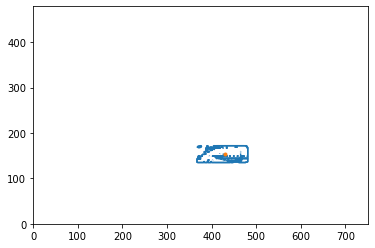

In [41]:
i = 40
x = range(mask[i].shape[1])
y = range(mask[i].shape[0])
X, Y = meshgrid(x, y)
levels = arange(0, 0.2, 0.1)

# imshow(img)
contour(X, Y, mask[i], levels, colors='C0')
plot([mean_point[i][1]], [mean_point[i][0]], ".", color="C1")


In [ ]:
mask

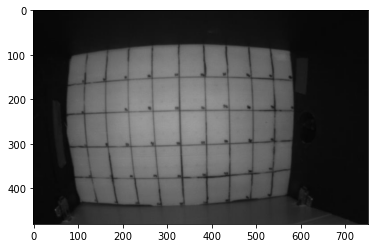

In [27]:
x = range(mask.shape[1])
y = range(mask.shape[0])
X, Y = meshgrid(x, y)
levels = arange(0, 0.2, 0.1)

imshow(img)
# contour(X, Y, mask, levels, colors='C0', linewidth=1)
# plot([mean_point[1]], [mean_point[0]], ".", color="C1")


In [44]:

mask = {}
mean_point = {}
model.eval()
with torch.no_grad():
    for f in glob('videos/frames/Odor1_*'):
        nframe = int(f.split(".")[0].split("e")[-1])
        img = Image.open(f).convert("RGB")
        prediction = model([img.to(device)])
        img = img.mul(255).permute(1, 2, 0).byte().numpy()
        mask[nframe] = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
        mean_point[nframe] = array(nonzero(mask[nframe])).mean(axis=1)


AttributeError: to

In [30]:
imread(f)

array([[[ 7,  7,  7],
        [ 7,  7,  7],
        [ 7,  7,  7],
        ...,
        [ 7,  7,  7],
        [ 7,  7,  7],
        [ 7,  7,  7]],

       [[ 7,  7,  7],
        [ 7,  7,  7],
        [ 7,  7,  7],
        ...,
        [ 7,  7,  7],
        [ 7,  7,  7],
        [ 7,  7,  7]],

       [[ 7,  7,  7],
        [ 7,  7,  7],
        [ 7,  7,  7],
        ...,
        [ 7,  7,  7],
        [ 7,  7,  7],
        [ 7,  7,  7]],

       ...,

       [[ 9,  9,  9],
        [ 9,  9,  9],
        [ 9,  9,  9],
        ...,
        [10, 10, 10],
        [10, 10, 10],
        [10, 10, 10]],

       [[ 9,  9,  9],
        [ 9,  9,  9],
        [ 9,  9,  9],
        ...,
        [10, 10, 10],
        [10, 10, 10],
        [10, 10, 10]],

       [[ 9,  9,  9],
        [ 9,  9,  9],
        [ 9,  9,  9],
        ...,
        [10, 10, 10],
        [10, 10, 10],
        [10, 10, 10]]], dtype=uint8)

### create uploadable frames directory


In [1]:
import os
from shutil import copyfile


In [36]:
for f in os.listdir('videos/frames_colored'):
    copyfile(f'videos/frames_colored/{f}',
             f'videos/uploadable/colored_frames/{f.split(".")[0]}_masked.{f.split(".")[1]}')
    copyfile(f'videos/frames/{f.split(".")[0]}.jpg',
             f'videos/uploadable/orig_frames/{f.split(".")[0]}.jpg')


### convert images to masks


In [2]:
from PIL import Image
import numpy
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [37]:
def convert_image_to_mask(image_path):
    npmask = numpy.array(Image.open(image_path))
    if len(npmask[0][0]) != 3:
        print(image_path, len(npmask[0][0]))
        return [-1]
    reshaped = npmask.reshape(1, -1, 3)[0]
    applied = numpy.apply_along_axis(
        lambda arr: False if arr.sum() < 50 else True, 1, reshaped)
    npmask_mask = applied.reshape(npmask.shape[:-1])
    return numpy.where(npmask_mask, 1, 0)


In [38]:
filespath = 'videos/uploadable'
for filename in os.listdir(f'{filespath}/colored_frames'):
    mask = convert_image_to_mask(f'{filespath}/colored_frames/{filename}')
    if len(mask) != 1:
        numpy.savetxt(f"{filespath}/masks/{filename.split('.')[0]}.txt", mask)


In [28]:
numpy.array(Image.open(f'{filespath}/colored_frames/{filename}'))


array([[[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       ...,

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0

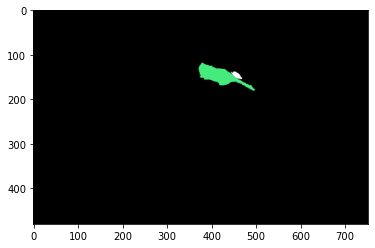

In [30]:
imshow(numpy.array(Image.open(f'{filespath}/colored_frames/{filename}')))


In [13]:
481280 / 480


1002.6666666666666

In [4]:
m = convert_image_to_mask('videos/frames_colored/Odor1_frame94.jpg')


In [8]:
numpy.savetxt("test.csv", m)


In [9]:
numpy.loadtxt("test.csv")


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

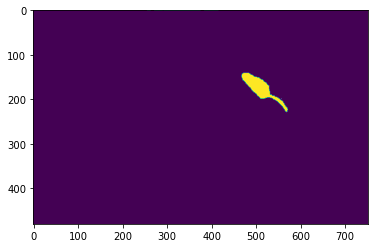

In [67]:
imshow(convert_image_to_mask('videos/frames_colored/Odor1_frame94.jpg'))


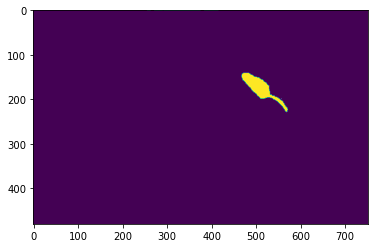

In [65]:
imshow(converted_mask)


In [29]:
conv(npmask)


True

(480, 3)

In [45]:
npmask.shape[:-1]


(480, 752)

In [47]:
npmask_mask = applied.reshape(npmask.shape[:-1])


In [51]:
numpy.where(npmask_mask, 1, 0).sum()


358375